# Computer Vision - Exercise 1

In this exercise, we are going to analyse the Hough transform, which is an algorithm for finding specific structures like lines and circles. 

In [2]:
import numpy as np
from skimage import io, feature, filters, transform, draw
from scipy import ndimage
import matplotlib.pyplot as plt

## Finding Edges - Question 1

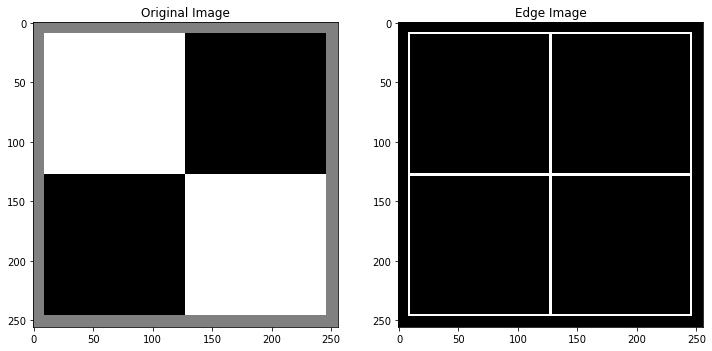

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [3]:
img = io.imread('ps1_matlab_template/input/ps1-input0.png', as_gray=True)
#edge_img = feature.canny(img)
edge_img = filters.sobel(img)
edge_img = (edge_img) > 0.1

fig, axs = plt.subplots(1, 2)
fig.set_figheight(12)
fig.set_figwidth(12)
axs[0].imshow(img, cmap='gray')
axs[0].set_title("Original Image")
axs[1].imshow(edge_img, cmap='gray')
axs[1].set_title("Edge Image")
plt.show()

#Convert the boolean image to an integer image
edge_img_float = edge_img.astype(float)

io.imsave("ps1_matlab_template/output/ps1-1-a-1(test).png", edge_img_float)

## Finding lines - Question 2

First of all, we are going to define the functions which are going to be used in the task of finding the lines in a given image.

In [4]:
def hough_peaks(H, num_peaks, neighborhood_size = np.array([5, 5])):
    threshold = 0.5*np.amax(H)
    #neighborhood_size = np.floor(np.array(H.shape) / 100.0) * 2 + 1
    
    '''data_max = ndimage.maximum_filter(H, neighborhood_size)
    maxima = (H == data_max)

    data_min = ndimage.minimum_filter(H, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)

    peaks = []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        y_center = (dy.start + dy.stop - 1)/2    
        peaks.append(list([int(y_center), int(x_center)]))
    '''
    num_rows, num_cols = H.shape
    peaks = []
    for i in range(num_peaks):
        H_sorted = np.sort(H.flatten())[::-1]
        peak_value = H_sorted[0]
        
        if peak_value >= threshold:
            x, y = np.where(H == peak_value)
            x = x[0]
            y = y[0]
            
            lowX = np.maximum(np.floor(x-neighborhood_size[0]), 0).astype(int)
            highX = np.minimum(np.ceil(x+neighborhood_size[0]), num_rows-1).astype(int)
            lowY = np.maximum(np.floor(y-neighborhood_size[1]), 0).astype(int)
            highY = np.minimum(np.ceil(y+neighborhood_size[1]), num_cols-1).astype(int)
            
            H[lowX:highX+1, lowY:highY+1] = 0

            peaks.append([x, y])
    return np.array(peaks)

def hough_lines_draw(image, peaks, theta):
    m = image.shape[0]
    n = image.shape[1]
    
    x = np.arange(0, n)
    H = np.zeros(image.shape)
    
    d_max = int(np.sqrt(m**2 + n**2))
    theta_max = theta[-1]
    plt.imshow(image, cmap='gray')
    
    plt.ylim(m, 0)
    for i in range(peaks.shape[0]):
        d = peaks[i, 0] - d_max
        theta = peaks[i, 1] - theta_max        
        if (theta == 0):
            theta = 0.000000001
        
        
        y = ((d - x*np.cos(np.deg2rad(theta)))/np.sin(np.deg2rad(theta))).astype(int)
        plt.plot(x, y, 'y')        
        
    return H

#It is possible to change the resolution of the Theta axis
#The resolution of the rho axis is 1
def hough_lines_acc(edge_image, Theta=np.arange(-90, 91)):
    m = edge_image.shape[0]
    n = edge_image.shape[1]
    
    rho_max = int(np.sqrt(m**2 + n**2))
    Theta_rad = np.deg2rad(Theta)
    H = np.zeros((2*rho_max+1, len(Theta)))
    
    for y in range(m):
        for x in range(n):
            if edge_image[y, x] == 1:
                d = np.round((x*np.cos(Theta_rad) + y*np.sin(Theta_rad))+rho_max).astype(int) #Approximation nearest integer
                H[d, Theta+Theta[-1]] += 1
                
    return H, np.arange(-rho_max, rho_max+2), Theta    

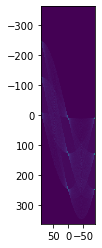

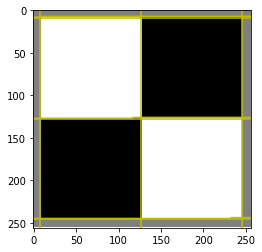

In [5]:
H, d, angles = hough_lines_acc(edge_img_float)
plt.imshow(H, extent=(angles[-1], angles[0], d[-1], d[0]))
plt.show()
peaks = hough_peaks(H, 10)
lines_images = hough_lines_draw(img, peaks, angles)

## Finding Lines - Question 3

In this part of the exercise we are going to add some noise to the image used recently.

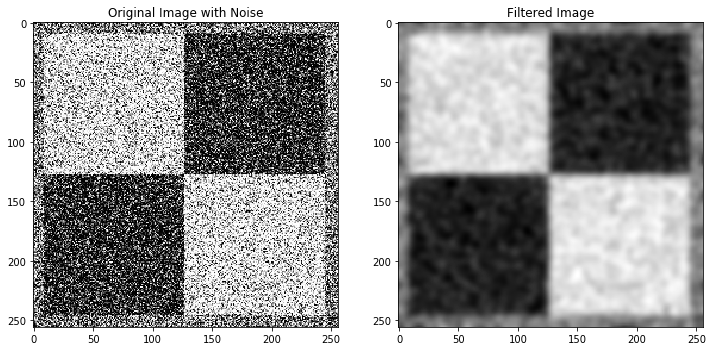

In [6]:
img_noise = io.imread('ps1_matlab_template/input/ps1-input0-noise.png', as_gray=True)

#Smoothing the image
sigma = 3
img_noise_filtered = filters.gaussian(img_noise, sigma)

fig, axs = plt.subplots(1, 2)
fig.set_figheight(12)
fig.set_figwidth(12)
axs[0].imshow(img_noise, cmap='gray')
axs[0].set_title("Original Image with Noise")
axs[1].imshow(img_noise_filtered, cmap='gray')
axs[1].set_title("Filtered Image")
plt.show()

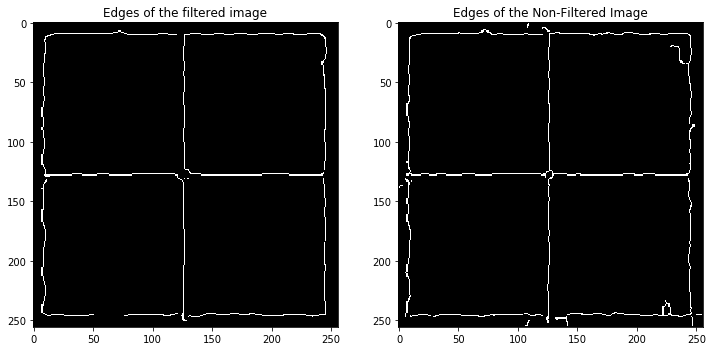

In [7]:
noise_edges_filtered = feature.canny(img_noise_filtered, 3)
noise_edges = feature.canny(img_noise, 3)

fig, axs = plt.subplots(1, 2)
fig.set_figheight(12)
fig.set_figwidth(12)
axs[0].imshow(noise_edges_filtered, cmap='gray')
axs[0].set_title("Edges of the filtered image")
axs[1].imshow(noise_edges, cmap='gray')
axs[1].set_title("Edges of the Non-Filtered Image")
plt.show()

Surprisingly, the two edges are not so different. This is because the canny filter applies a gaussian filter which has the effect of smooth the noise.

Now, let's find the lines!

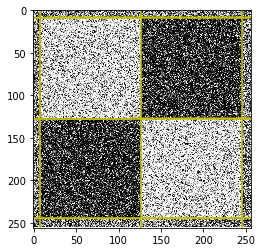

In [8]:
#First let's try the smoothed version
H, d, angles = hough_lines_acc(noise_edges_filtered)
#plt.imshow(H)
peaks = hough_peaks(H, 10)
lines_images = hough_lines_draw(img_noise, peaks, angles)

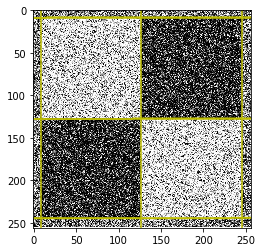

In [9]:
#Now let's try the smoothed the non-filtered version
H, d, angles = hough_lines_acc(noise_edges)
#plt.imshow(H)
peaks = hough_peaks(H, 10)
lines_images = hough_lines_draw(img_noise, peaks, angles)

## Finding Lines - Question 4

Now, we are going to test the Hough transform in Real images.

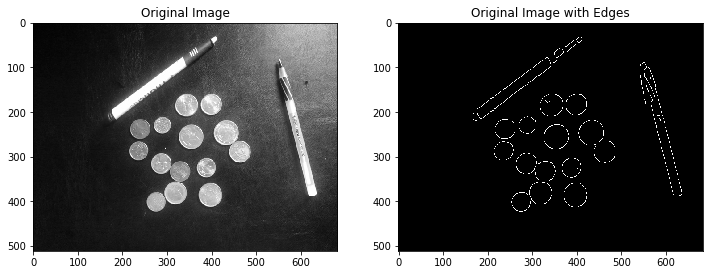

In [10]:
coin_pen = io.imread('ps1_matlab_template/input/ps1-input1.png', as_gray=True)

sigma = 1
coin_pen_edges = feature.canny(coin_pen, 3)

fig, axs = plt.subplots(1, 2)
fig.set_figheight(12)
fig.set_figwidth(12)
axs[0].imshow(coin_pen, cmap='gray')
axs[0].set_title("Original Image")
axs[1].imshow(coin_pen_edges, cmap='gray')
axs[1].set_title("Original Image with Edges")
plt.show()

[[1377   76]
 [1358   76]
 [1115  143]
 [1137  143]]


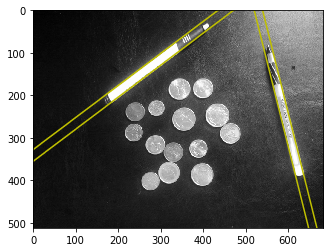

In [11]:
#Now let's try the smoothed the non-filtered version
H, d, angles = hough_lines_acc(coin_pen_edges)
#plt.imshow(H)
peaks = hough_peaks(H, 4)
print(peaks)
lines_images = hough_lines_draw(coin_pen, peaks, angles)

## Finding Circles - Question 5

Now we will use the Hough Transform for finding circles.

In [62]:
#This function receives the radius of the circle and an image contaning its edges. It returns the Hough accumulator
#of the image
def hough_circles_acc(edges, r):
    num_rows = edges.shape[0]
    num_cols = edges.shape[1]
    
    grad_theta = np.deg2rad(np.arange(0, 361))
    
    a_range = num_cols-1
    b_range = num_rows-1
    
    a_bin = a_range/num_rows
    b_bin = b_range/num_cols
    
    H = np.zeros((num_rows, num_cols))
    for y in range(num_rows):
        for x in range(num_cols):
            if (edges[y, x] == 1):
                for grad in grad_theta:
                    a = x - r*np.cos(grad)
                    b = y + r*np.sin(grad)
                    
                    a_index = int(a/a_bin+0.5)
                    b_index = int(b/b_bin+0.5)
                    H[a_index, b_index] += 1
    
    return H, a_bin, b_bin

def find_circles(edges, radius_range):
    range_list = np.arange(radius_range[0], radius_range[1]+1)
    
    H = np.zeros(edges.shape)
    for r in range_list:
        H_r = hough_circles_acc(edges, r)
        
        H += H_r
        
    peaks = hough_peaks(H, 10)    
    
def hough_circles_draw(image, peaks, r):
    num_rows = image.shape[0]
    num_cols = image.shape[1]
    
    H = np.zeros(image.shape)
    
    fig, ax = plt.subplots() 
    ax.imshow(image, cmap='gray')
    for i in range(peaks.shape[0]):
        a = peaks[i, 0]
        b = peaks[i, 1]
    
        circle = plt.Circle((a, b), r, color='r', fill=False)
        ax.add_artist(circle)

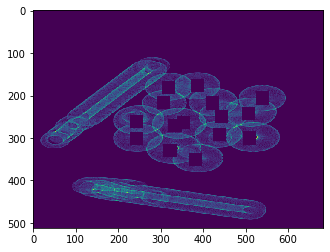

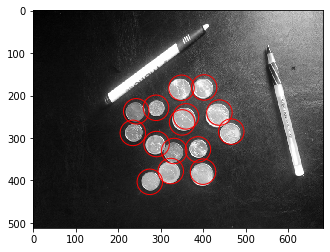

In [67]:
H, a_bin, b_bin = hough_circles_acc(coin_pen_edges.astype(int), 20)
peaks = hough_peaks(H, 15, np.array([15, 15]))

plt.imshow(H)

hough_circles_draw(coin_pen, peaks*[a_bin, b_bin], 30)